For this exercise, practice how to create a `DataBunch` given the folder structure of BIWI dataset.

Then practice how to do regression with images.

## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.version import __version__
print(__version__)

1.0.46


## Getting and converting the data

In [2]:
URLs.BIWI_HEAD_POSE

'https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose'

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path

PosixPath('/home/paperspace/.fastai/data/biwi_head_pose')

In [4]:
# required calibration
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

`np.genfromtxt()`

Load data from a text file. ie, turns text into a numpy array.

In [5]:
# helper function
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

# required preprocessing
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

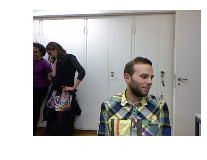

In [6]:
fname = '09/frame_00667_rgb.jpg'
img = open_image(path/fname)
img.show()

In [7]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3)
get_ctr(fname)

tensor([263.9104, 428.5814])

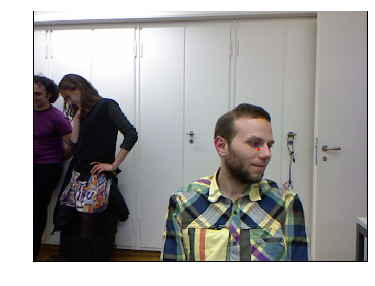

In [8]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

---

## Creating a dataset

Start practicing from here.

In [9]:
path

PosixPath('/home/paperspace/.fastai/data/biwi_head_pose')

In [10]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/10'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/12.obj'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/06.obj'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/05'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/14'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/19.obj'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/13.obj'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/15'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/11'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/19'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/20'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/03.obj'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/21'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/03'),
 PosixPath('/home/paperspace/.fastai/data/biwi_head_pose/02'),
 PosixPath('/home/paperspace/.fasta

In [21]:
'''
Where are the inputs and how to create them?
How to split the data into a training and validation sets?
How to label the inputs?
What transforms to apply?
How to add a test set?
How to wrap in dataloaders and create the DataBunch
'''

tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name == '13')
       .label_from_func(get_ctr)
       .transform(tfms=get_transforms(tfms), tfm_y=True, size=(160,140))
       .databunch(bs=64)
       .normalize(imagenet_stats))

In [ ]:
# Transforms to apply
# tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

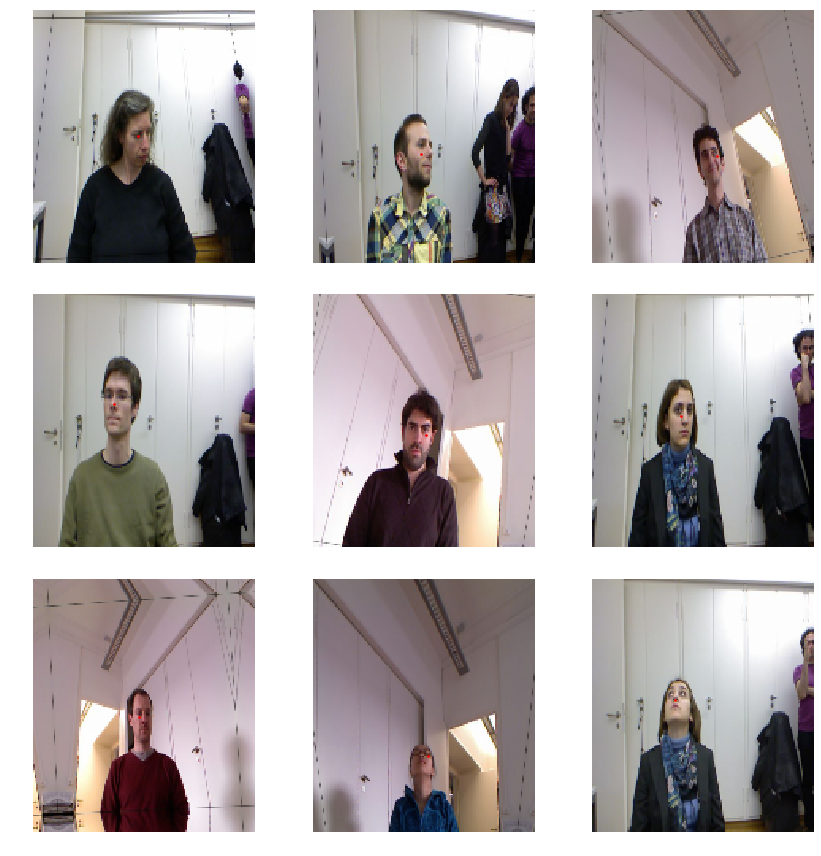

In [22]:
data.show_batch(rows=3)

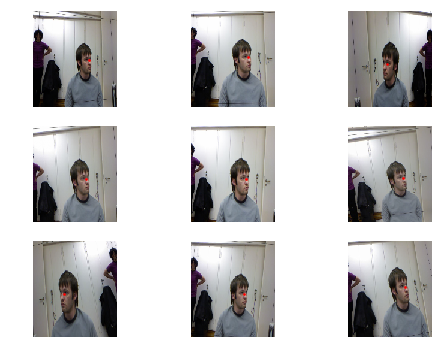

In [23]:
## This is what it looks like after applying transforms:
def _plot(i,j,ax):
    # plot one
    x,y = data.train_ds[0]
    x.show(ax, y=y)

# plot many in a grid
plot_multi(_plot, 3, 3, figsize=(8,6))

[PointsItemList](https://docs.fast.ai/vision.data.html#PointsItemList)

## Train model

The rest of the steps are pretty much the same drill as practiced in the previous lessons.

In [25]:
learn = create_cnn(data, arch=models.resnet34).to_fp16()

In [28]:
learn.loss_func

FlattenedLoss of MSELoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


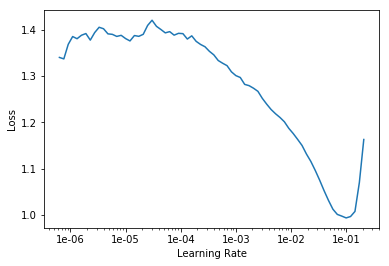

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
lr = 1e-2

In [29]:
# fit 5 cycles
# fp16 takes 4 minutes
learn.fit_one_cycle(cyc_len=6, max_lr=slice(lr))

epoch,train_loss,valid_loss,time
1,0.084043,0.003563,01:03
2,0.026908,0.007214,01:00
3,0.012610,0.002751,01:00
4,0.007304,0.002321,01:00
5,0.004905,0.001774,01:00
6,0.003944,0.001631,00:57


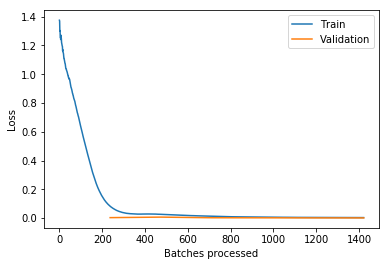

In [30]:
# plot loss curve
learn.recorder.plot_losses()

In [31]:
# save
learn.save('stage-1')

In [ ]:
# learn.load('stage-1');

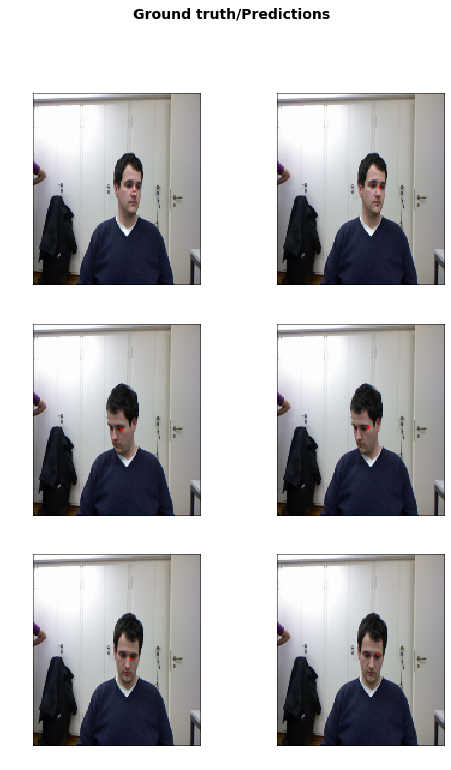

In [32]:
# show results
learn.show_results(rows=3)